# NOAA's Coastal Ocean Reanalysis (CORA)
### Import necessary library

In [1]:
import dask
import intake
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as sp

## Approach to get points

<Axes: >

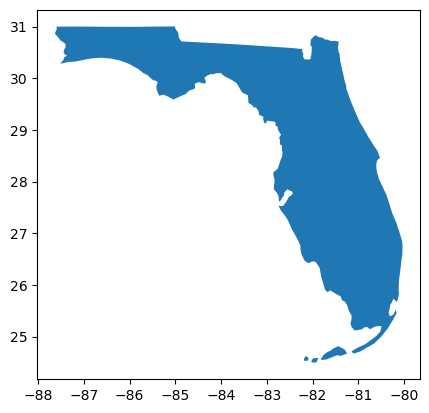

In [4]:
#load florida shapefile
import geopandas as gpd
fl_boundary = gpd.read_file(r"F:\onedrive\OneDrive - University of Central Florida\florida_shpe\state_fl.shp")
fl_boundary.plot()

In [5]:
# Get the geometry of the first row (which is a MultiPolygon)
first_row_geometry = fl_boundary.iloc[0]['geometry']  # Access the geometry of the first row
data = []
# Check if it's a MultiPolygon
if first_row_geometry.geom_type == 'MultiPolygon':
    # Choose a specific polygon by index (e.g., the first polygon)
    selected_polygon = first_row_geometry.geoms[3]  # Choose the polygon at index 3

    # Get the exterior coordinates of the selected polygon
    exterior_coords = list(selected_polygon.exterior.coords)
    data.extend(exterior_coords)
    # If there are any holes (interior rings), extract them
    interior_coords = [list(interior.coords) for interior in selected_polygon.interiors]
    data.extend(interior_coords)
    # Print the coordinates of the selected polygon (exterior and interior if present)
    print("Exterior coordinates:")

else:
    print("The geometry is not a MultiPolygon.")

df = pd.DataFrame(data, columns=['Longitude', 'Latitude'])

# Display the DataFrame
print(df)


Exterior coordinates:
     Longitude   Latitude
0   -87.592069  30.951466
1   -87.598942  30.997428
2   -87.598834  30.997428
3   -87.519538  30.997558
4   -87.425796  30.998064
..         ...        ...
352 -87.442296  30.692667
353 -87.523626  30.738291
354 -87.542273  30.767487
355 -87.634948  30.865863
356 -87.592069  30.951466

[357 rows x 2 columns]


In [10]:
df['geometry'] = gpd.points_from_xy(x = df['Longitude'], y = df['Latitude'], crs = 'EPSG:4326')
df['geometry']

0      POINT (-87.59207 30.95147)
1      POINT (-87.59894 30.99743)
2      POINT (-87.59883 30.99743)
3      POINT (-87.51954 30.99756)
4      POINT (-87.42580 30.99806)
                  ...            
352    POINT (-87.44230 30.69267)
353    POINT (-87.52363 30.73829)
354    POINT (-87.54227 30.76749)
355    POINT (-87.63495 30.86586)
356    POINT (-87.59207 30.95147)
Name: geometry, Length: 357, dtype: geometry

In [11]:
boundary = gpd.GeoDataFrame(geometry = df['geometry'])
boundary = boundary.to_crs(epsg = 4326)
boundary['lat'] = df['Latitude']
boundary['lon'] = df['Longitude']

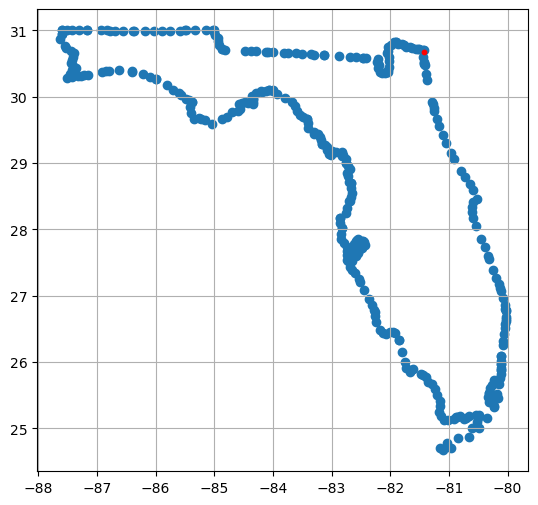

In [12]:
boundary.plot(figsize=(10, 6))
x = -81.430902  # Example longitude 87.5  -81.430902  30.676487
y = 30.676487  # Example latitude 30.45
plt.scatter(x, y, color='red', s=10, label='Point of Interest')
plt.grid()

## Remove north border of florida which is not coastal

<Axes: >

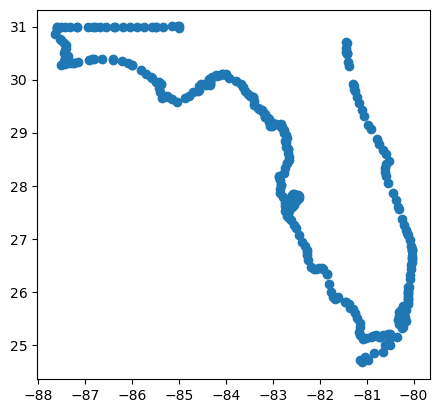

In [13]:
#filter out some portion
lat = 30.3
lon1 = -81.5
lon2 = -85.00
filtered_boundary = boundary[
    ~((boundary['lat'] > lat) &
      (boundary['lon'].between(lon2, lon1)))
]
filtered_boundary.plot()
        

<Axes: >

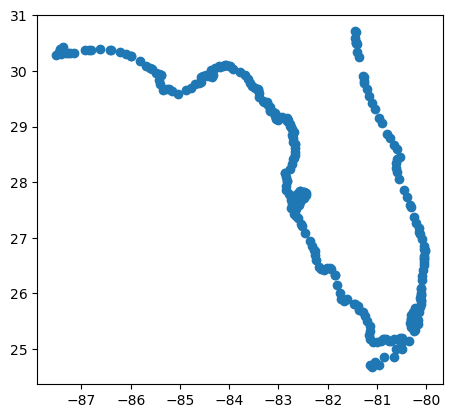

In [14]:
#filter out more 
lat1 = 30.45
lon3 = -88.00
lon4 = -84.00
sec_fil = filtered_boundary[~((filtered_boundary['lat'] > lat1) &
    (filtered_boundary['lon'].between(lon3, lon4)))
]
sec_fil.plot()
#this is what we are left with

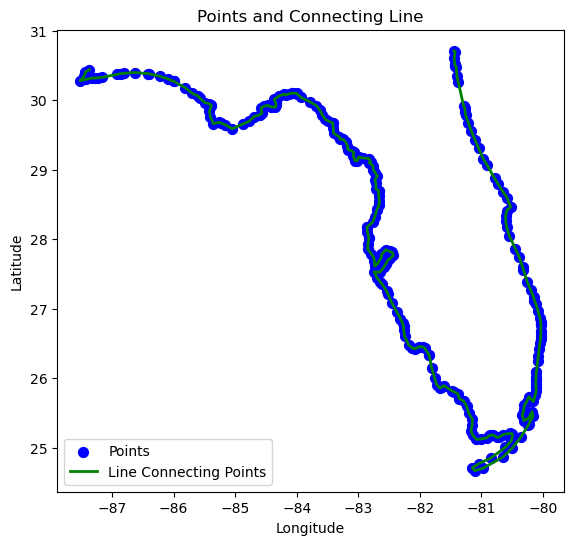

In [15]:
from shapely.geometry import LineString
line = LineString(sec_fil.geometry)
# Plot the existing points (optional)
ax = sec_fil['geometry'].plot(figsize=(8, 6), color='blue', markersize=50, label='Points')

# Extract x and y coordinates for the line plot
x, y = line.xy

# Plot the line connecting the points
plt.plot(x, y, color='green', linewidth=2, label='Line Connecting Points')
#intersected_border.plot(ax=plt.gca(), color = 'red')
# Add labels, legend, and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Points and Connecting Line')

# Show the plot
plt.show()

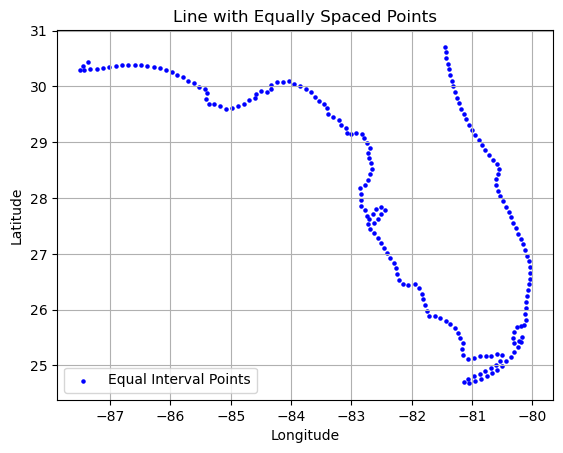

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Extract coordinates from point geometries
coords = [(point.x, point.y) for point in sec_fil.geometry]

# Create a LineString from the coordinates
line = LineString(coords)

# Define the number of equally spaced points 
num_points = 200

# Get equally spaced points along the line
equal_points = [line.interpolate(i/num_points, normalized=True) for i in range(num_points+1)]

# Extract latitude (y) and longitude (x) of each point
equal_lat_lon = [(point.y, point.x) for point in equal_points]

# Plot the equally spaced points
plt.scatter([p.x for p in equal_points], [p.y for p in equal_points], color='blue', label='Equal Interval Points', s=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.legend()
plt.title('Line with Equally Spaced Points')
plt.show()


Things to consider here is that these equal spaced points mostly on open ocean as state boundary covers some area from open
Ocean. In next few block of codes I will move those points little towards land so that they are in coast otherwise some of these points
would generate nan values.

In [18]:
lat_lon  = pd.DataFrame(equal_lat_lon, columns = ['lat', 'lon'])

In [19]:
atlantic_latlon = lat_lon[((lat_lon['lat'] >= 27.00) &
    (lat_lon[lat_lon['lon'] >= 82.00]))
]
east_coast = gpd.GeoDataFrame(atlantic_latlon, geometry=gpd.points_from_xy(x = atlantic_latlon['lon'], y = atlantic_latlon['lat'], crs = 'EPSG:4326'))

In [20]:
# Filter based on latitude and longitude
atlantic_latlon = lat_lon[
    (lat_lon['lat'] >= 27) & 
    (lat_lon['lon'] >= -82)
]

# Create a GeoDataFrame from the filtered latitude and longitude data
east_coast = gpd.GeoDataFrame(
    atlantic_latlon, 
    geometry=gpd.points_from_xy(
        x=atlantic_latlon['lon'], 
        y=atlantic_latlon['lat'], 
        crs='EPSG:4326'
    )
)


<Axes: >

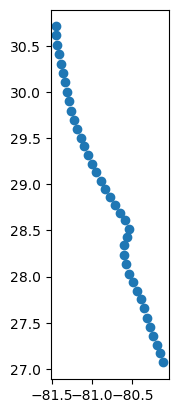

In [233]:
east_coast.plot()

In [234]:
push = 0.1
east_coast['lon1']=east_coast['lon'] + 0.05
east_coast['lat1']=east_coast['lat'].copy()

In [235]:
lower_atlantic = lat_lon[
    (lat_lon['lat'] <= 27) & 
    (lat_lon['lon'] >= -80.5)
]

# Create a GeoDataFrame from the filtered latitude and longitude data
lower_east_coast = gpd.GeoDataFrame(
    lower_atlantic, 
    geometry=gpd.points_from_xy(
        x=lower_atlantic['lon'], 
        y=lower_atlantic['lat'], 
        crs='EPSG:4326'
    )
)


<Axes: >

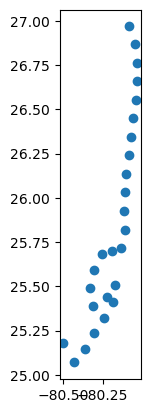

In [236]:
lower_east_coast.plot()

In [237]:
lower_east_coast['lon1'] = lower_east_coast['lon'] + 0.05
lower_east_coast['lat1'] = lower_east_coast['lat'].copy()

In [238]:
lower_gulf =lat_lon[
    (lat_lon['lat'] <= 29.6) & 
    (lat_lon['lon'] <= -81.5)
]
lower_gulf_coast = gpd.GeoDataFrame(
    lower_gulf, 
    geometry=gpd.points_from_xy(
        x=lower_gulf['lon'], 
        y=lower_gulf['lat'], 
        crs='EPSG:4326'
    )
)


<Axes: >

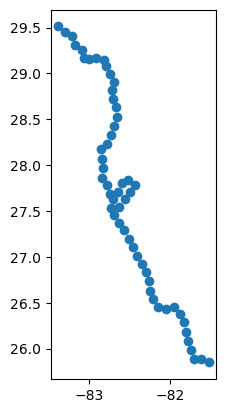

In [239]:
lower_gulf_coast.plot()

In [240]:
lower_gulf_coast['lon1'] = lower_gulf_coast['lon'] - push
lower_gulf_coast['lat1'] = lower_gulf_coast['lat'].copy()

In [241]:
upper_gulf = lat_lon[
    (lat_lon['lat'] >= 29.6) & 
    (lat_lon['lon'] <= -83.00)
]
upper_gulf_coast = gpd.GeoDataFrame(
    upper_gulf, 
    geometry=gpd.points_from_xy(
        x=upper_gulf['lon'], 
        y=upper_gulf['lat'], 
        crs='EPSG:4326'
    )
)


<Axes: >

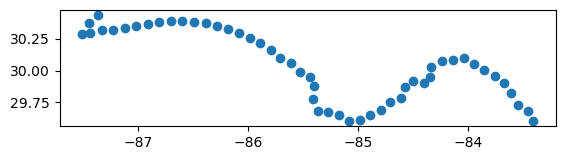

In [242]:
upper_gulf_coast.plot()

In [243]:
upper_gulf_coast['lat1'] = upper_gulf_coast['lat'] - push
upper_gulf_coast['lon1'] = upper_gulf_coast['lon'].copy()

In [244]:
bottom = lat_lon[
    (lat_lon['lat'] <= 26.00) & 
    (lat_lon['lon'].between(-81.5, -80.5))
]
bottom_coast = gpd.GeoDataFrame(
    bottom, 
    geometry=gpd.points_from_xy(
        x=bottom['lon'], 
        y=bottom['lat'], 
        crs='EPSG:4326'
    )
)


In [245]:
bottom_coast['lon1'] = bottom_coast['lon'] - push
bottom_coast['lat1'] = bottom_coast['lat'].copy()

In [246]:
cat_coast = pd.concat([lower_gulf_coast, upper_gulf_coast, east_coast, lower_east_coast, bottom_coast ], ignore_index = True)

In [247]:
cat_coast['new_geometry'] = gpd.points_from_xy(x = cat_coast['lon1'], y = cat_coast['lat1'], crs = ('EPSG:4326'))

<Axes: >

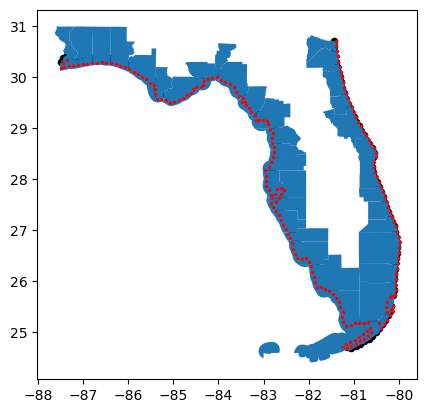

In [255]:
cat_coast['geometry'].plot( color = 'black', markersize =20)
combined_county.to_crs(epsg=4326).plot(ax= plt.gca())
cat_coast['new_geometry'].plot(ax= plt.gca(), color = 'red', markersize =2)

<Axes: >

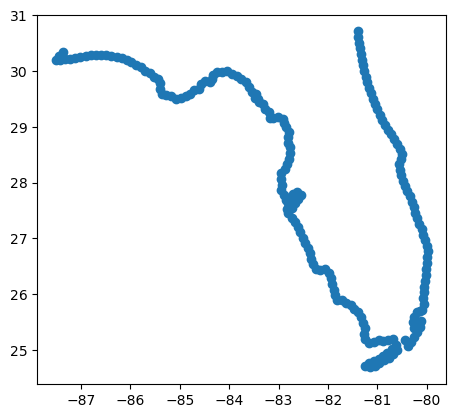

In [256]:
cat_coast['new_geometry'].plot()

In [257]:
ds = cat_coast[['lon1', 'lat1']]
ds = ds.rename(columns={'lon1': 'lon', 'lat1': 'lat'})
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     201 non-null    float64
 1   lat     201 non-null    float64
dtypes: float64(2)
memory usage: 3.3 KB


In [258]:
df = ds.copy()

## CORA data extraction 

In [260]:
catalog = intake.open_catalog("s3://noaa-nos-cora-pds/CORA_intake.yml",storage_options={'anon':True})
list(catalog)

['CORA-V1-fort.63',
 'CORA-V1-maxele.63',
 'CORA-V1-fort.64',
 'CORA-V1-500m-grid-1979-2022']

In [261]:
ds = catalog["CORA-V1-fort.63"].to_dask()

In [262]:
def area(x1, y1, x2, y2, x3, y3):
 
    return (abs((x1 * (y2 - y3) + x2 * (y3 - y1)
                + x3 * (y1 - y2)) / 2.0))

In [263]:
def define_kd_tree(ds):
    e = (ds.element.values.astype(int) - 1)

    num_elems = len(e)
    x_vals = ds.x.values
    y_vals = ds.y.values

    xe=np.mean(x_vals[e],axis=1)
    ye=np.mean(y_vals[e],axis=1)
    tree = sp.KDTree(np.c_[xe,ye])

    areas = [area(x_vals[e[k][0]],y_vals[e[k][0]],\
                  x_vals[e[k][1]],y_vals[e[k][1]],\
                  x_vals[e[k][2]],y_vals[e[k][2]])for k in range(0, num_elems)]
    return tree, areas, e, x_vals, y_vals

In [264]:
%%time
#%run setup_kdtree.ipynb
tree, areas, e, x_vals, y_vals = define_kd_tree(ds)

CPU times: total: 9.73 s
Wall time: 11.6 s


In [265]:
print("Number of locations=", len(df.lon)) #

Number of locations= 201


In [266]:
def find_triangle(x_vals, y_vals, e,lat,lon):
    k = 10
    dist, ii = tree.query([lon,lat],k=k)

    triangle_i = -1

    for i in range(0,k):

      a1 = area(lon,lat,\
                x_vals[e[ii[i]][0]],y_vals[e[ii[i]][0]],\
                x_vals[e[ii[i]][1]],y_vals[e[ii[i]][1]])

      a2 = area(lon,lat,\
                x_vals[e[ii[i]][1]],y_vals[e[ii[i]][1]],\
                x_vals[e[ii[i]][2]],y_vals[e[ii[i]][2]])
      a3 = area(lon,lat,\
                x_vals[e[ii[i]][0]],y_vals[e[ii][i][0]],\
                x_vals[e[ii[i]][2]],y_vals[e[ii][i][2]])

      t_area = a1 + a2 + a3
      if abs(t_area - areas[ii[i]]) < 0.00000001:
        triangle_i = ii[i]
        break
    if(triangle_i == -1):
        print("ERROR for " ,lat,lon)
    return triangle_i

In [267]:
nodes = len(df.lon) # how many nodes?
t_indices = np.zeros(shape=(nodes), dtype=int) # preallocate with zeros
weights = np.zeros(shape=((nodes, 3)), dtype=float) # preallocate with zeros
triangle_arr = np.zeros(shape=((nodes, 3)), dtype=int) # preallocate with zeros

for i in range(0, nodes):
    t_indices[i] = find_triangle(x_vals, y_vals, e, df.lat[i], df.lon[i]) # use find_triangle function to find the element numbers

    triangle_arr[i, :] = e[t_indices[i]] # find the nodes of the elements
    x_dist = df.lon[i] - x_vals[triangle_arr[i, :]] # find distance between lon values
    y_dist = df.lat[i] - y_vals[triangle_arr[i, :]] # find distance between lat values
    dist = np.sqrt(x_dist * x_dist + y_dist * y_dist) # find hypotenuse(s) (distance (degrees) between queried point(s) and the nodes)
    if np.any(dist == 0):

        weights[i, :] = np.where(dist == 0, 1, 0) # if you are exactly on the node, the weight will be 1. Otherwise, set to zero.
    else:
        weights[i, :] = 1 / dask.array.sqrt(x_dist * x_dist + y_dist * y_dist) # set weights to 1 divided by the distances (in degrees) of queried point(s) from the nodes; 
        # since the distances are fractions, the shortest distances get the largest weights


unique_nodes = np.unique(triangle_arr) # sorted unique nodes
mapped_triangle = np.searchsorted(unique_nodes, triangle_arr) # indices of the nodes

In [268]:
%%time
start_t = "2015-01-01"
end_t = "2022-12-31"


zeta_tslice = ds["zeta"].sel(time=slice(start_t, end_t), node=unique_nodes).compute() # select water level data by time slice at the nodes of elements that hold queried points

num_ts = len(zeta_tslice) # number of time samples
nodes = len(mapped_triangle) # number of nodes

t = np.zeros((num_ts, nodes, 3), dtype=float) # preallocate with zeros

for t_i in range(0, 3):
    t[:, :, t_i] = zeta_tslice[:, mapped_triangle[:, t_i]] * weights[:, t_i] #  for the nodes at each time step (hourly)

zeta_interp = np.sum(t, axis=2) / np.sum(weights, axis=1)
#print(zeta_interp[0, 0:10])
plot_arr = xr.DataArray(
    data=zeta_interp,
    coords=dict(lon=(["node"], df.lon), lat=(["node"], df.lat), time=zeta_tslice.time),
    dims=["time", "node"],
)

CPU times: total: 2h 10min 53s
Wall time: 2h 17min 32s


In [290]:
import geopandas as gpd
import pandas as pd
import xarray as xr

# Assuming combined_county is a GeoDataFrame with county polygons
# and df (from earlier) has the lon, lat coordinates as a pandas DataFrame

# Convert plot_arr lon, lat to a GeoDataFrame for spatial operations
geometry = gpd.points_from_xy(df.lon, df.lat)
plot_gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Perform a spatial join between the points and the polygons
joined = gpd.sjoin(plot_gdf, combined_county, how="inner", op="intersects")


In [ ]:
# Group by 'county' (or appropriate column) and 'time' and take the maximum water level for each group
for time in plot_arr.time.values:
    df_time = pd.DataFrame({'lon': df.lon, 'lat': df.lat, 'water_level': plot_arr.sel(time=time).values})
    df_time['geometry'] = geometry
    joined_time = gpd.sjoin(gpd.GeoDataFrame(df_time, geometry='geometry'), combined_county, how='inner')
    
    # Group by county and take the max water level
    max_by_county = joined_time.groupby('County')['water_level'].max()
    max_by_county['time'] = time
    # Convert list to DataFrame
    county_max_df = pd.DataFrame(max_by_county)
    county_max_df['time'] = county_max_df['time'].to_datetime()
    #county_max_df.set_index('time', inplace=True)
    # Resample the data to daily frequency and take the maximum for each day
    county_daily_max = county_max_df.resample('D').max()
    county_daily_max.to_csv(f"F:\onedrive\OneDrive - University of Central Florida\cora\water_level_data\{County}water_levels.csv", index = True)
    print(f'Done for {County}')


## Optionally we can plot water levels for a node

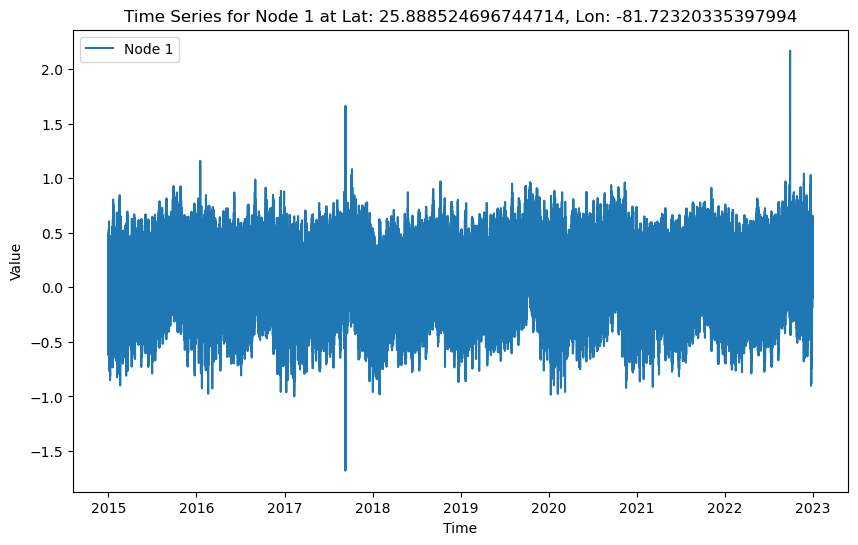

In [213]:
import xarray as xr
import matplotlib.pyplot as plt

# Select data for a specific node (e.g., node index 0)
node_index = 1
node_data = plot_arr.isel(node=node_index)

# Plot the selected node's data over time
plt.figure(figsize=(10, 6))
plt.plot(node_data['time'], node_data, label=f'Node {node_index}')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Time Series for Node {node_index} at Lat: {node_data.lat.values}, Lon: {node_data.lon.values}')
plt.legend()

# Show plot
plt.show()


## Plot the entire CORA dataset ( not suggested as it takes long time to plot)

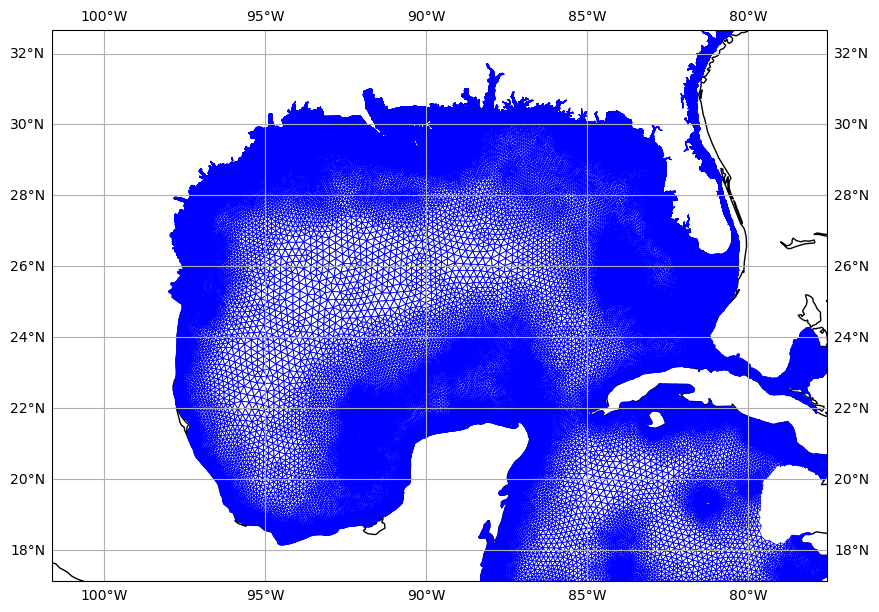

In [237]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

def plot_coastal_and_grid_on_map(coastal_border_gdf, x_vals, y_vals, e):
    # Create figure and Cartopy axis with PlateCarree projection
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Plot coastal counties (previous plot)
    coastal_border_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Loop over each triangle in the grid and plot it (overlay the grid)
    for i in range(len(e)):
        # Get the coordinates of the triangle's vertices
        triangle_x = x_vals[e[i]]
        triangle_y = y_vals[e[i]]

        # Plot the triangular element
        ax.plot(np.append(triangle_x, triangle_x[0]),  # Close the triangle
                np.append(triangle_y, triangle_y[0]),  # Close the triangle
                color='blue', linewidth=0.5, transform=ccrs.PlateCarree())

    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Coastal Border with Grid of Triangular Elements')

    plt.show()

# Assuming you have x_vals, y_vals, e, and coastal_border_gdf already defined
plot_coastal_and_grid_on_map(coastal_border_gdf, x_vals, y_vals, e)
